In [1]:
from plantcv import plantcv as pcv
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats, ndimage, signal
from skimage import filters, morphology

import os
from PIL import Image

import pandas as pd

import utils

from importlib import reload

In [2]:
src = '../raw/'
time = '4pm'
rep = 7

foldername = time + ' Inc Rep ' + str(rep)
numfiles = len(glob(src + foldername + '/*.JPG'))

dst = '../preproc/prelim/'

In [3]:
idx = 450
filename = src + foldername + '/' + foldername + ' ({}).JPG'.format(idx+1)
filename

raw, path, imgname = pcv.readimage(filename, mode='rgb')
rawstd = np.var(raw, axis=2, ddof=1)
rawmean = np.mean(raw, axis = 2)
rawmax = np.max(raw, axis=2)
rawmin = np.min(raw, axis=2)

rawdiff = rawmax - rawmin
rawavg = rawmax//2 + rawmin//2

hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)


In [4]:
stdmask = (rawstd > 50) | (rawmean > 210)

hmask = ((h < 40) & (h > 0)) & (raw[:,:,1] > 70) & stdmask

img = raw.copy()
for i in range(3):
    img[:,:,i] *= hmask

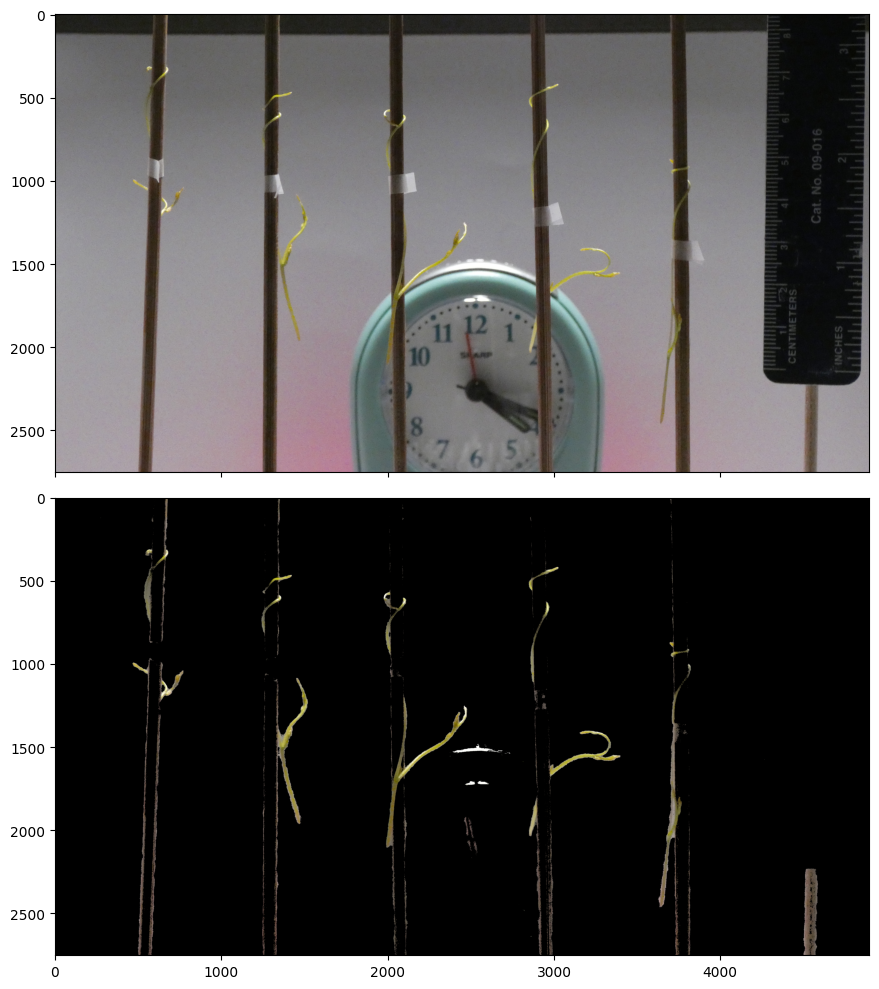

In [5]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)
ax[0].imshow(raw[:,:,::-1])
ax[1].imshow(img[:,:,::-1])
fig.tight_layout()

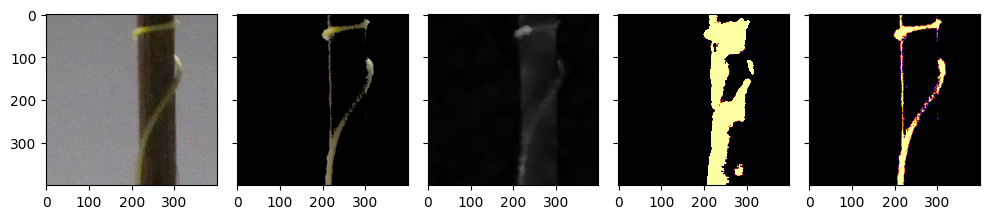

In [7]:
#ss = np.s_[250:1000, 100:900]
ss = np.s_[300:1000, 1200:1500]
ss = np.s_[500:1100, 1800:2200]
#ss = np.s_[300:1200, 2600:3200]
ss = np.s_[900:1300, 3500:3900]

fig, ax = plt.subplots(1,5,figsize=(10,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[ss][:,:,::-1])
#ax[1].imshow(rawstd[ss], cmap='inferno')
ax[1].imshow(img[:,:,::-1][ss])
gthr = 50
ax[2].imshow(rawdiff[ss], cmap='Greys_r', vmin=0, vmax=255)
rthr = 20
ax[3].imshow(rawdiff[ss], cmap='inferno', vmin=rthr, vmax=rthr+1)
ax[4].imshow(hmask[ss], cmap='inferno', vmin=0)

fig.tight_layout()

In [57]:
patch = img[ss][:,:,::-1]
rpatch = raw[ss][:,:,::-1]

median = ndimage.median_filter(patch[:,:,1], size=11)

labels = utils.get_largest_element(median, thr=0.05)
labels = ndimage.binary_fill_holes(labels)

thr = rpatch.copy()
thr[labels == 0] = 0

foo = rpatch.copy()
foo[labels > 0] = 0

4 components	 1 preserved
[10010   530    46    22]


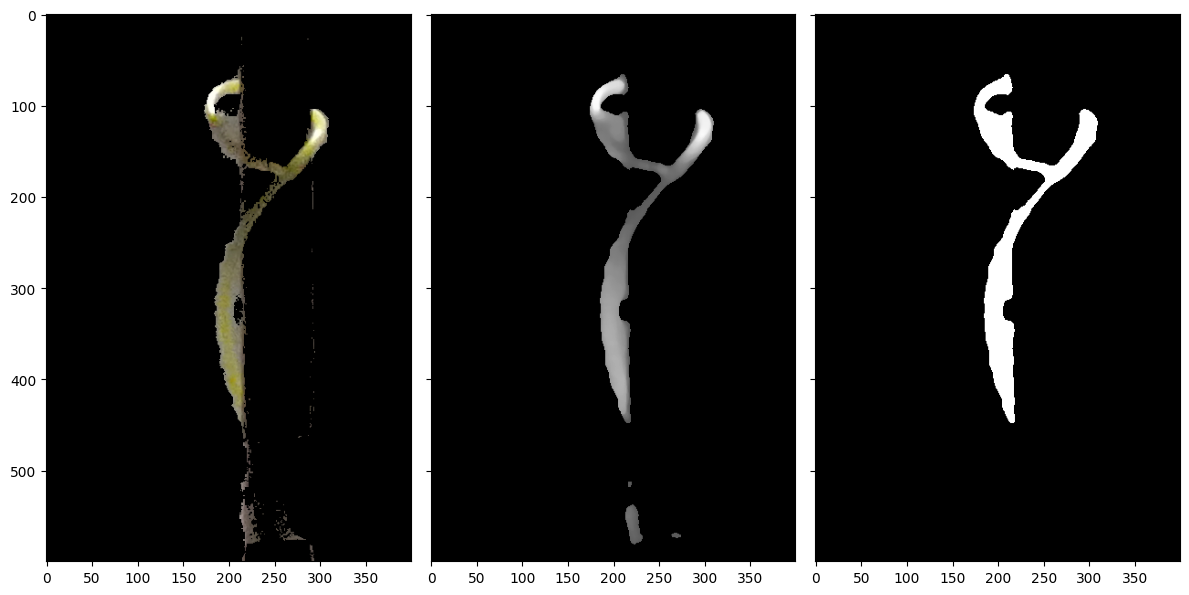

In [58]:
anchory = 620
fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch, origin='lower');

ax[1].imshow(median, cmap='Greys_r', vmax=255)
ax[2].imshow(labels, cmap='Greys_r', vmin=0)

#ax[2].axvline(anchory, c='yellow')


fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

In [59]:
coords = np.asarray(np.nonzero(labels))
skeleton = morphology.skeletonize(labels)
skcoords = np.asarray(np.nonzero(skeleton))

In [60]:
root = np.max(skcoords[0])
foo = skcoords[:,skcoords[0] == root]
foo = np.min(foo[1])
root = np.array([foo, root])
print('Root:\t', root)

Root:	 [216 445]


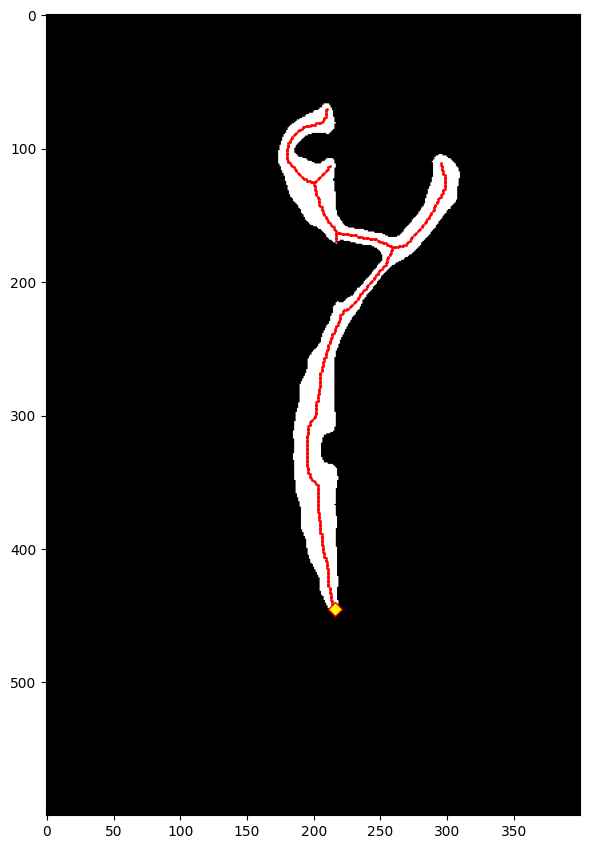

In [61]:
fig, ax = plt.subplots(1,1,figsize=(6,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(labels, cmap='Greys_r', vmin=0)
#ax[0].axvline(anchory, c='yellow')
ax[0].scatter([root[0]], [root[1]], marker='D', color='yellow', s=50, edgecolor='red', zorder=10)
#ax[0].plot(vine[:,0], vine[:,1], c='red', lw=3, zorder=1)
ax[0].scatter(skcoords[1], skcoords[0], color='r', s=1)

fig.tight_layout();

filename = time + '_rep{:02d}_{}_prelim_1'.format(rep, idx+1)

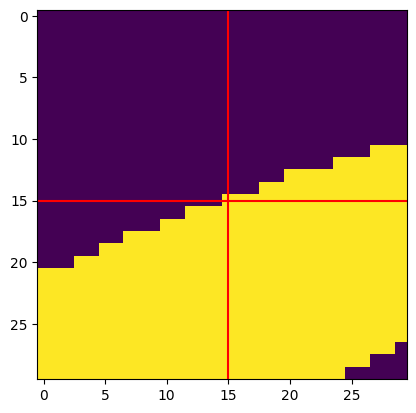

In [151]:
buff = jumplim
view = np.s_[vine[-1,1]-buff:vine[-1,1]+buff, vine[-1,0]-buff:vine[-1,0]+buff]
plt.imshow(labels[view])
plt.axvline(buff, c='r')
plt.axhline(buff, c='r')

In [ ]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [22]:
xlimit = 4200

medians = np.median(raw[:,:,0], axis=0)
maxis = np.max(raw[:,:,2], axis = 0).astype(int)
peaks, _ = signal.find_peaks(255 - medians, distance=300, height=150, prominence=50)

In [24]:
peaks

array([ 593, 1281, 2062, 2921, 3771, 4430])

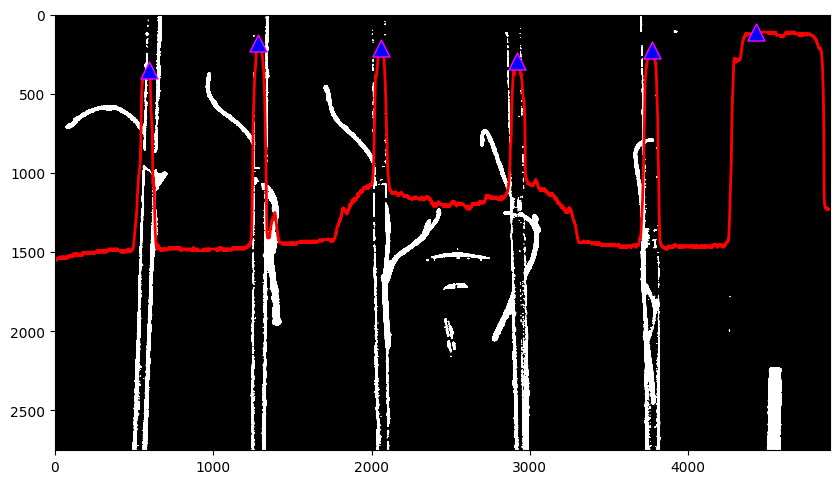

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(img[:,:,0], cmap='Greys_r', vmin=0, vmax=1);
ax[0].plot(10*(medians), c='r', lw=2, zorder=2);
ax[0].scatter(peaks, 10*medians[peaks], c='blue', marker='^', zorder=3, edgecolor='magenta', s=150);
#ax[0].plot(10*(maxis), c='b', lw=2);

In [ ]:
buffx = 100
buffy = 50
stick = []

stick.append(np.s_[buffx:-buffx, 0:peaks[1]-buffy, :])
for i in range(1, len(peaks)-1):
    stick.append(np.s_[buffx:-buffx, peaks[i-1]+buffy:peaks[i+1]-buffy, :])
print(len(stick))

In [ ]:
jdx = 4
fig, ax = plt.subplots(2,len(stick),figsize=(12,10))

ax = ax.ravel()

for i in range(len(stick)):
    ax[i].imshow(img[stick[i]][:,:,::-1]);
    ax[i].axis('off')
    
    ax[i+5].imshow(np.max(img[stick[i]], axis=2), vmax=1)
    ax[i+5].axis('off')

fig.tight_layout()

In [ ]:
i = 0

hsv = cv2.cvtColor(img[stick[i]], cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

fig, ax = plt.subplots(1,4,figsize=(12,7), sharex=True, sharey=True)

ax[0].imshow(h, cmap='inferno');
ax[1].imshow(s, cmap='inferno');
ax[2].imshow(v, cmap='inferno', vmin=0, vmax=255);
ax[3].imshow(img[stick[i]])

fig.tight_layout()

In [ ]:
plt.imshow(v > 62, cmap='Greys_r');